In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

In [3]:
data_path = "~/ml/Pawpularity/"

In [4]:
raw_data = pd.read_csv(data_path + 'train.csv')
raw_data.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [9]:
pets = raw_data.drop('Id', axis=1)
# print(pets)
X_pets = pets.drop('Pawpularity', axis=1)
# print(X_pets)
y_pets = pets['Pawpularity'].round(-1)
# print(y_pets)

0       60
1       40
2       30
3       20
4       70
        ..
9907    20
9908    70
9909    20
9910    20
9911    30
Name: Pawpularity, Length: 9912, dtype: int64


In [10]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X_pets, y_pets,
                                                random_state=1)

In [11]:
from sklearn.naive_bayes import GaussianNB # 1. choose model class
model = GaussianNB()                       # 2. instantiate model
model.fit(Xtrain, ytrain)                  # 3. fit model to data
y_model = model.predict(Xtest)             # 4. predict on new data

In [12]:
from sklearn.metrics import accuracy_score, hamming_loss
print(accuracy_score(ytest, y_model))
print(hamming_loss(ytest, y_model))

0.023809523809523808
0.9761904761904762


Unsure if this is an appropriate model. This seems to be for classification but this model should predict rating. Is that different?

# Feature Selection Testing
Based on: https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e

Select k best features for strongest relationship with "Pawpulariy" using chi square as the rating. Info, Occlusion, and Action are the top 3

In [13]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
X = pets.iloc[:,0:12]  #independent columns
y = pets.iloc[:,-1]    #target column i.e price range
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=12)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(12,'Score'))

            Specs       Score
10           Info  113.821843
9       Occlusion  111.846985
4          Action  105.652374
7         Collage   99.748302
6           Group   97.332347
11           Blur   96.409636
0   Subject Focus   91.020631
5       Accessory   76.051293
8           Human   74.850206
1            Eyes   27.443891
3            Near   14.405352
2            Face   12.184476


Rate features based on model scoring. 
First test is Extra Trees: Accessory, Human, and Collage
Second test is Random Forest: Human, Accessory, and Near

0.06850282485875706
[0.02131052 0.07664335 0.0878699  0.08709585 0.06620905 0.12387497
 0.09551228 0.09865719 0.11499988 0.06922926 0.07858746 0.08001031]
0.06850282485875706


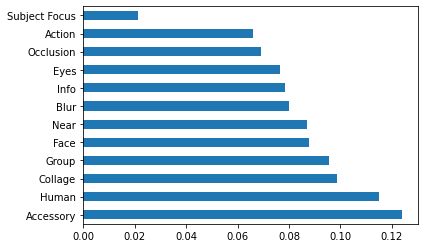

In [17]:
X = pets.iloc[:,0:12]  #independent columns
y = pets.iloc[:,-1]    #target column i.e price range
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
model = ExtraTreesClassifier()
model.fit(X,y)
y_model = model.predict(X)
print(accuracy_score(y, y_model))
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
print(model.score(X, y))
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(12).plot(kind='barh')
plt.show()

[0.02280736 0.08275424 0.09236889 0.10675724 0.05744685 0.10007781
 0.08817675 0.09443233 0.10346679 0.09578267 0.07793186 0.07799722]
0.06850282485875706


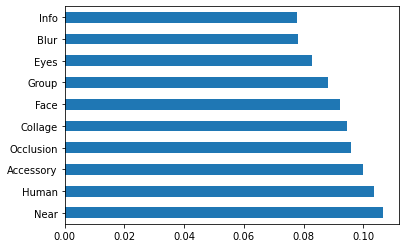

In [18]:
model2 = RandomForestClassifier()
model2.fit(X,y)
print(model2.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
print(model2.score(X, y))
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model2.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

Correlation matrix heatmap: Blur, Group, and Accessory

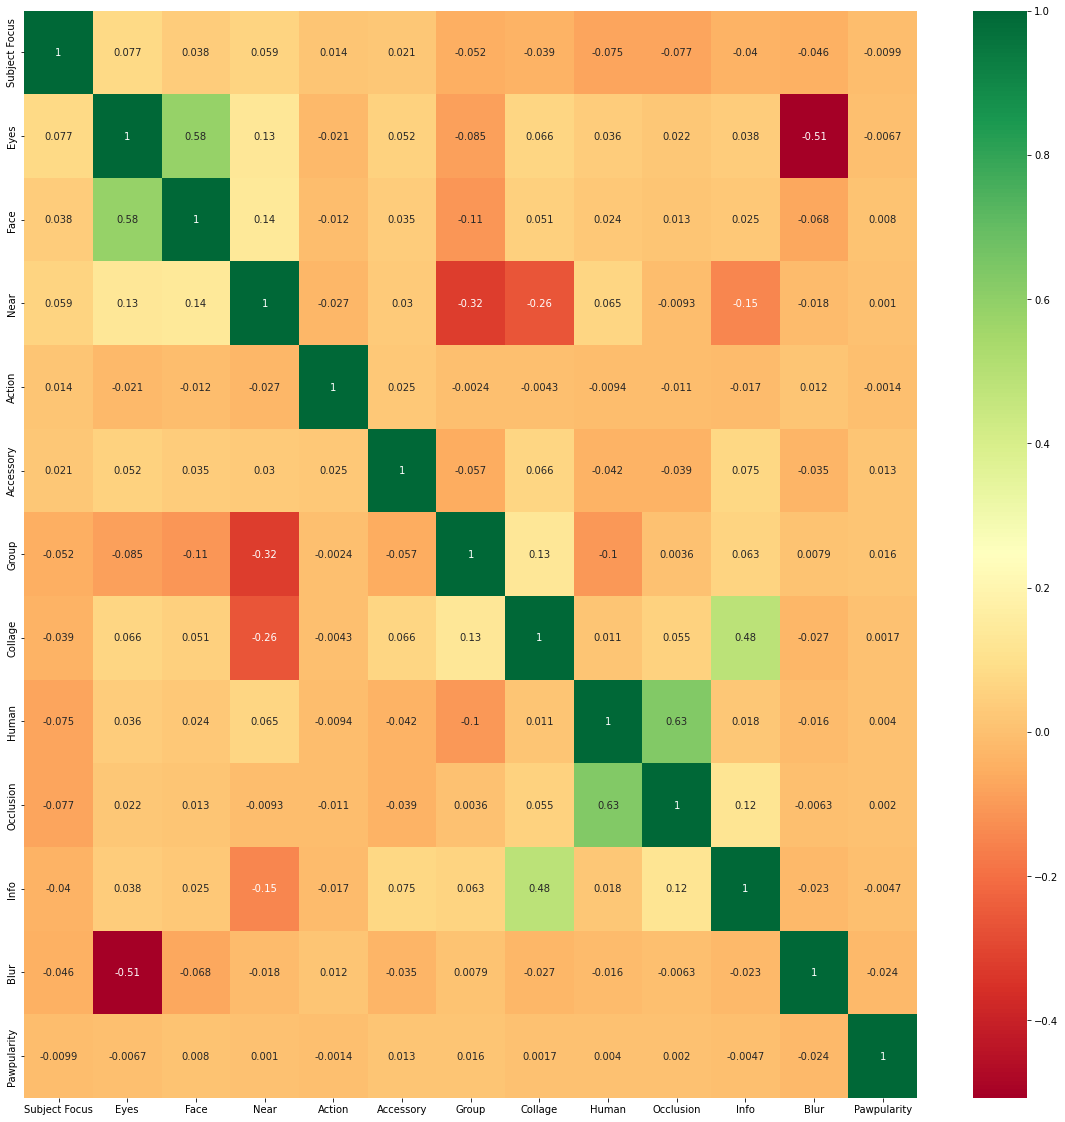

In [16]:
X = pets.iloc[:,0:12]  #independent columns
y = pets.iloc[:,-1]    #target column i.e pawpularity score
#get correlations of each features in dataset
corrmat = pets.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(pets[top_corr_features].corr(),annot=True,cmap="RdYlGn")

All these methods of data analysis support the idea that the metadata does not strongly point to any final determination of "Pawpularity".